# Importando librerías y funciones

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms
import matplotlib.colors as colors
from shapely.geometry.polygon import LinearRing



#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal

#Librería de estadística
import scipy as sp
from scipy.stats import pearsonr,spearmanr

#librería para manejo de fechas
from datetime import datetime,timedelta

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

Función para obtener realizar un análisis espectral

In [3]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1/len(serie))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

# Cargando los datos

In [4]:
rutas = np.array(np.sort(glob.glob("/home/franklin/Documentos/GitHub/TDG/Dataset/Glorys_CMEMS_Monthly/*.nc")),dtype="str")

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [d,lat,v,temp,u,time,lon,ssh]=reading_netcdf(rutas[i])
    else:
        [d2,lat2,v2,temp2,u2,time2,lon2,ssh2]=reading_netcdf(rutas[i])
        ssh=np.concatenate((ssh,ssh2))
        time=np.concatenate((time,time2))
print(nc.Dataset(rutas[0]))

depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees_C
uo (12, 1, 241, 1873) m s-1
time (12,) hours since 1950-01-01
longitude (1873,) degrees_east
zos (12, 241, 1873) m


depth (1,) m
latitude (241,) degrees_north
vo (12, 1, 241, 1873) m s-1
thetao (12, 1, 241, 1873) degrees

In [9]:
ssh[ssh<=-1000]=np.nan
da=[datetime(1950,1,1,0,0,0)+timedelta(hours=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)
new_array = np.array(date.to_pydatetime(), dtype=object)
ssh_copy=np.copy(ssh)

# Definiendo la región y la serie temporal

A continuación se preparan las series de datos espacio-temporales a usar y se determina la serie temporal final que será evaluada a través de el análisis espectral

In [16]:
(1/12)*110

9.166666666666666

In [10]:
lat_max = 3.85
lat_min = 3.65
lon_max = -77.2
lon_min = -78

ind_lat = np.where((lat<=lat_max) & (lat>=lat_min))[0]
ind_lon = np.where((lon<=(360+lon_max)) & (lon>=(360+lon_min)))[0]

La serie temporal que se determinará para la región del océano pacífico colombiano será el promedio longitudinal y latitudinal de los datos obtenidos

In [11]:
lon

array([130.     , 130.08333, 130.16667, ..., 285.83334, 285.91666,
       286.     ], dtype=float32)

In [12]:
x_tick_labels = [u'140\N{DEGREE SIGN}E', u'160\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}', u'160\N{DEGREE SIGN}W',
                 u'140\N{DEGREE SIGN}W',u'120\N{DEGREE SIGN}W',u'100\N{DEGREE SIGN}W',u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-10\N{DEGREE SIGN}N', u'-5\N{DEGREE SIGN}N',
                 u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N',
                 u'10\N{DEGREE SIGN}N']

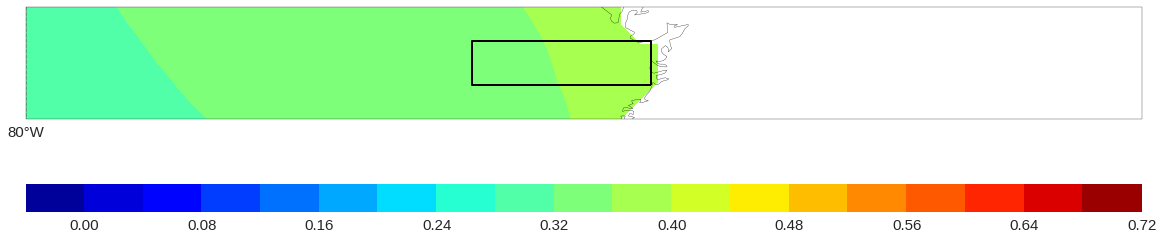

In [13]:
lns = [lon_max, lon_max, lon_min, lon_min]
lts = [lat_min, lat_max, lat_max,lat_min]
ring = LinearRing(list(zip(lns, lts)))

fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,ssh[10,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
# ct=ax.contour(x,y,ssh,20,transform=ccrs.PlateCarree(),colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines(resolution='10m')



ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)

ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

ax.set_xlim((100,105))
ax.set_ylim((3.5,4))

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [17]:
sla_lat=np.nanmean(ssh[:,ind_lat],axis=1)
serie_ssh=np.nanmean(sla_lat[:,ind_lon],axis=1)
serie_ssa=pd.Series(serie_ssh-np.mean(serie_ssh),index=date)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'sla [m]')

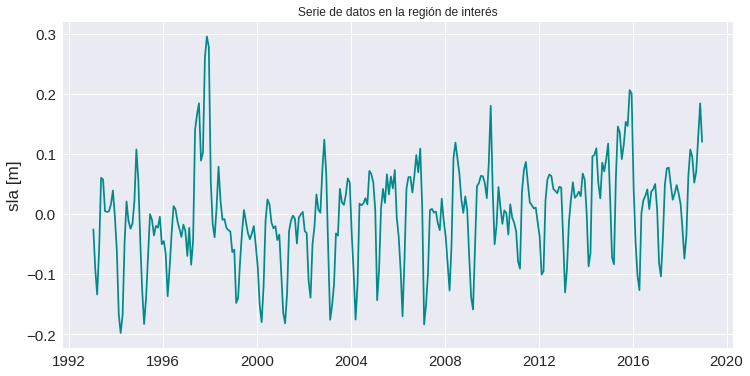

In [18]:
plt.figure(figsize=(12,6))
plt.title("Serie de datos en la región de interés")
plt.plot(serie_ssa,c="darkcyan")
plt.ylabel("sla [m]")
# plt.savefig(".\Graficas\Series.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Realizando el análisis espectral

In [19]:
sla_fourier,sla_freq_pos,sla_potencias,sla_periodos,sla_freq,=T_fourier(serie_ssa.values)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


# Graficando el espectro de potencias

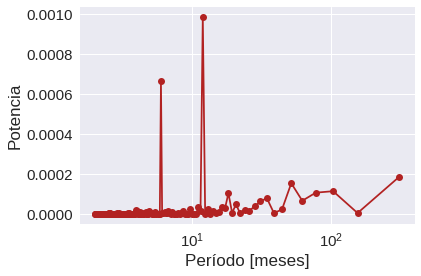

In [20]:
plt.figure()
plt.plot(sla_periodos[sla_freq_pos],sla_potencias[sla_freq_pos],'-o',c="firebrick")
plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.savefig(".\Graficas\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Seleccionando la banda de interés

In [21]:
freq_fil=np.copy(sla_fourier)
freq_fil[np.where((np.abs(1/sla_freq)<24) | (np.abs(1/sla_freq)>12*6))]=0

Pot_fil=np.abs(freq_fil*1/len(freq_fil))**2

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


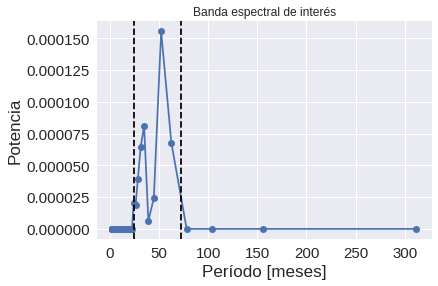

In [22]:
plt.figure()
plt.title("Banda espectral de interés")
plt.plot(sla_periodos[sla_freq_pos],Pot_fil[sla_freq_pos],'-o')
# plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.axvline(24,0,1,ls='--',c="k")
plt.axvline(12*6,0,1,ls='--',c="k")
# plt.xlim(0,24)
plt.savefig(".\Graficas\Banda espectral interes.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Mapas de varianza

In [23]:
var=np.zeros((len(lat),len(lon)))
var_banda=np.zeros((len(lat),len(lon)))
var_porcentaje=np.zeros((len(lat),len(lon)))
# matriz_inversa=np.zeros((len(time)),len(lat),len(lon))

for i in range(len(lat)):
    for j in range(len(lon)):
        point=ssh_copy[:,i,j]
        d=np.where(np.isnan(point)==True)[0]
        if len(d)==0:
            tf_p,fp_p,pot_p,per_p,f_p=T_fourier(point)
            pos_banda=np.where((np.abs(per_p)>24) & (np.abs(per_p)<12*6))[0]
            var_banda[i,j]=sum(pot_p[pos_banda])
            var[i,j]=np.var(point)
            var_porcentaje[i,j]=((var_banda[i,j])/np.var(point))*100

            
        else:
            var_banda[i,j]=np.NaN
            var[i,j]=np.NaN
            var_porcentaje[i,j]=np.NaN

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [25]:
n_rez=4
spearman_rez=np.zeros((n_rez,len(lat),len(lon)))
spearman=np.zeros((len(lat),len(lon)))
for r in range(n_rez):
    for i in range(len(lat)):
        for j in range(len(lon)):
            point=ssh_copy[:,i,j]
            d=np.where(np.isnan(point)==True)[0]
            if len(d)==0:
#                 pearson[i,j]=pearsonr(serie_ssa.values,point)[0]
                if r==0:
                    spearman[i,j]=spearmanr(serie_ssa.values,point)[0]
                else:
                    spearman[i,j]=spearmanr(serie_ssa.values[:-1-r],point[1+r:])[0]
            else:
#                 pearson[i,j]=np.NaN
                    spearman[i,j]=np.NaN
    spearman_rez[r,:,:]=spearman

In [26]:
ssh.shape

(312, 241, 1873)

In [27]:
spearman_rez.shape

(4, 241, 1873)

# Varianza para cada píxel

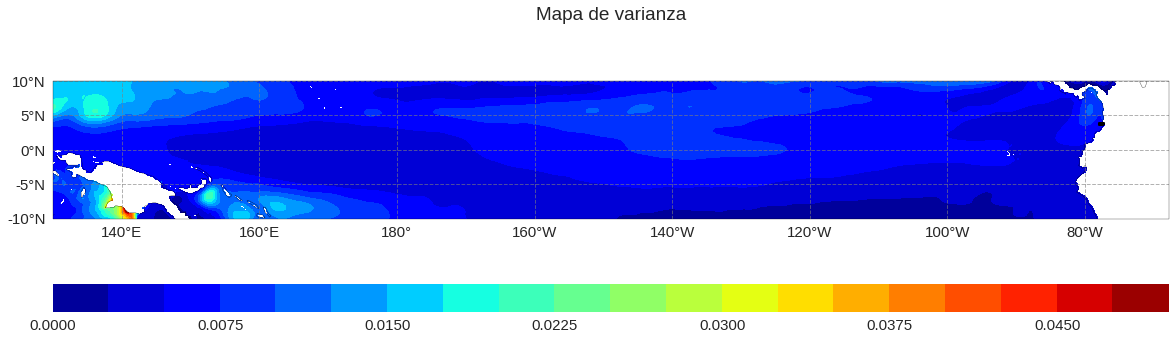

In [28]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de varianza",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()

ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)

ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Varianza en la banda

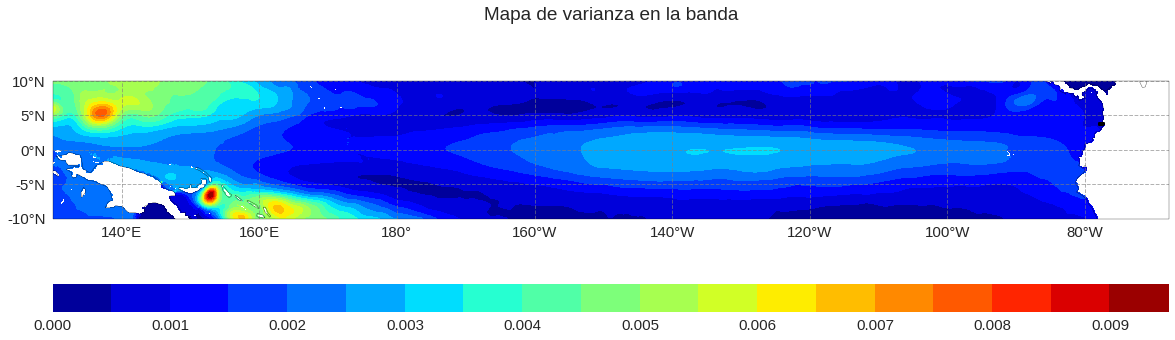

In [29]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de varianza en la banda",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_banda,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()


ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)


ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)

cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Porcentaje de varianza

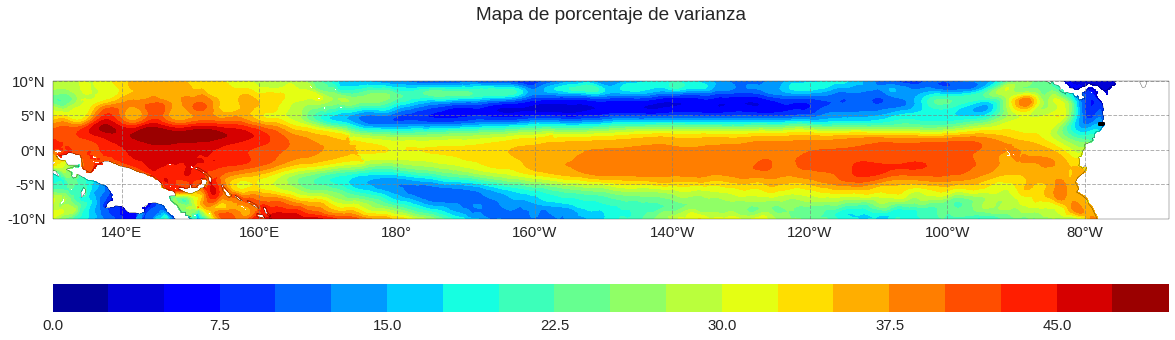

In [30]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title("Mapa de porcentaje de varianza",y=1.4,fontsize=19)
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_porcentaje,20,transform=ccrs.PlateCarree(),cmap="jet")

gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
ax.coastlines()


ax.set_xticks(np.arange(-40, 120, 20))
ax.set_xticklabels(x_tick_labels)


ax.set_yticks(np.arange(-10, 11, 5))
ax.set_yticklabels(y_tick_labels)
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Correlación de Pearson y Spearman

In [31]:
# fig=plt.figure(figsize=(20,20))
# ax=fig.add_subplot(projection=ccrs.PlateCarree())
# ax.set_title("Mapa de Correlación de Pearson",y=1.4,fontsize=19)
# x,y=np.meshgrid(lon,lat)
# cf=ax.contourf(x,y,pearson_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=1, color='gray', alpha=0.6, linestyle='--')
# gl.xlabel_style = {'size': 18, 'color': 'black'}
# gl.ylabel_style = {'size': 18, 'color': 'black'}
# ax.coastlines()
# cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
# cbar.ax.tick_params(labelsize=15) 

# plt.show()

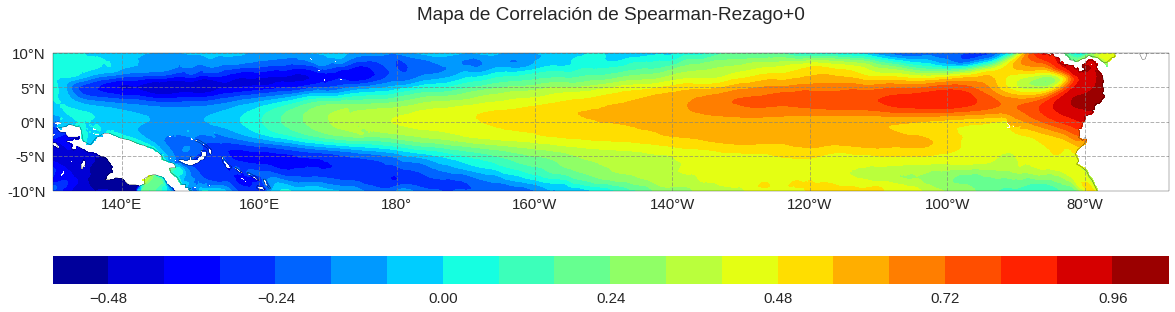

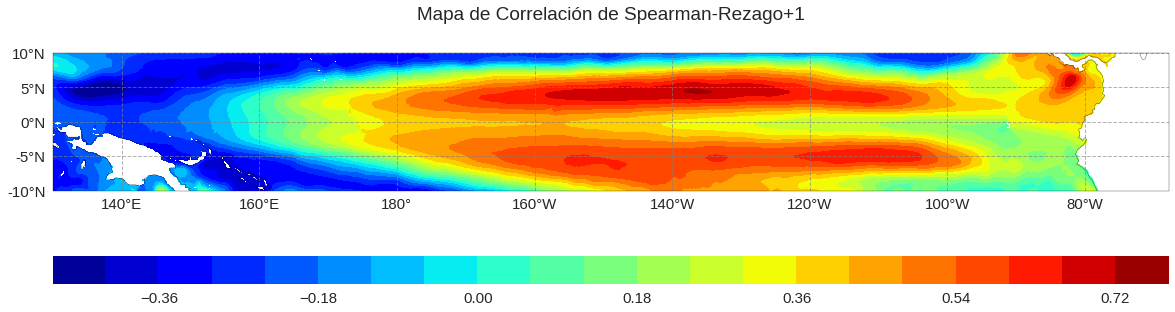

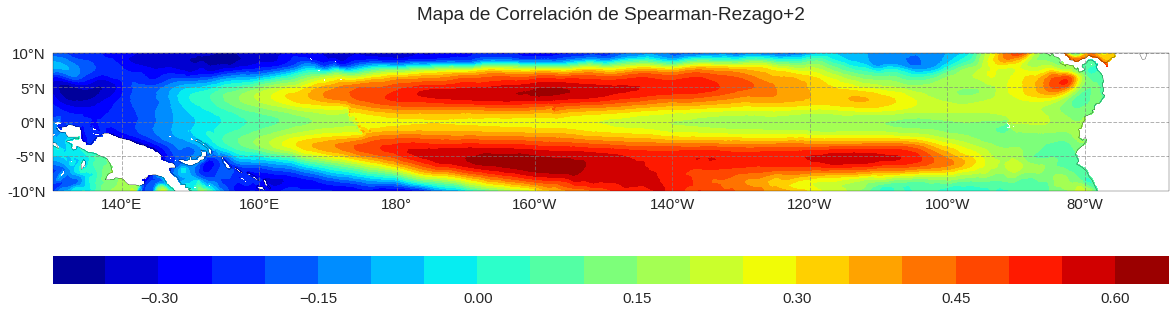

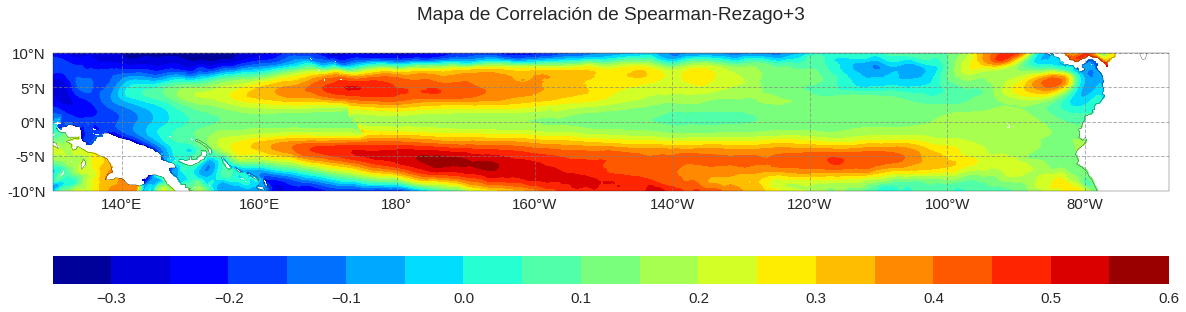

In [32]:
for i in range(n_rez):
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title("Mapa de Correlación de Spearman-Rezago+"+str(i),y=1.2,fontsize=19)
    x,y=np.meshgrid(lon,lat)
    cf=ax.contourf(x,y,spearman_rez[i,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
    gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
#     ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
    ax.coastlines()
    
    ax.set_xticks(np.arange(-40, 120, 20))
    ax.set_xticklabels(x_tick_labels)

    
#     if i==1:
#         ax.set_xlim((40,60))

    ax.set_yticks(np.arange(-10, 11, 5))
    ax.set_yticklabels(y_tick_labels)

    cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
    cbar.ax.tick_params(labelsize=15) 

    plt.show()

# Máximos para cada rezago

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


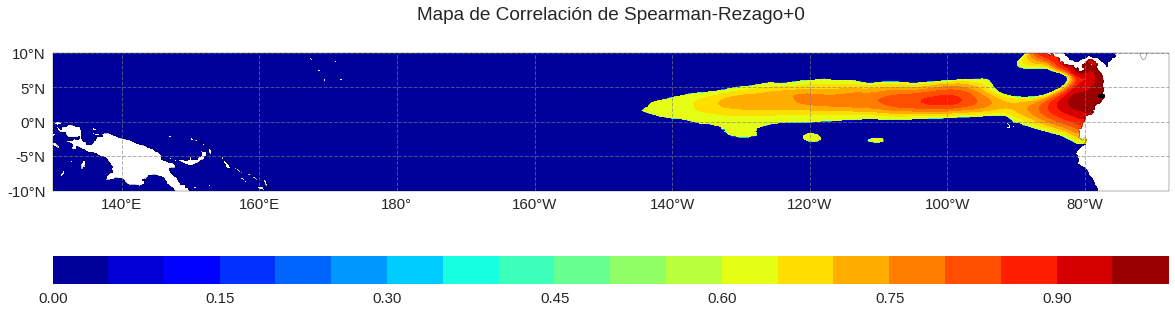

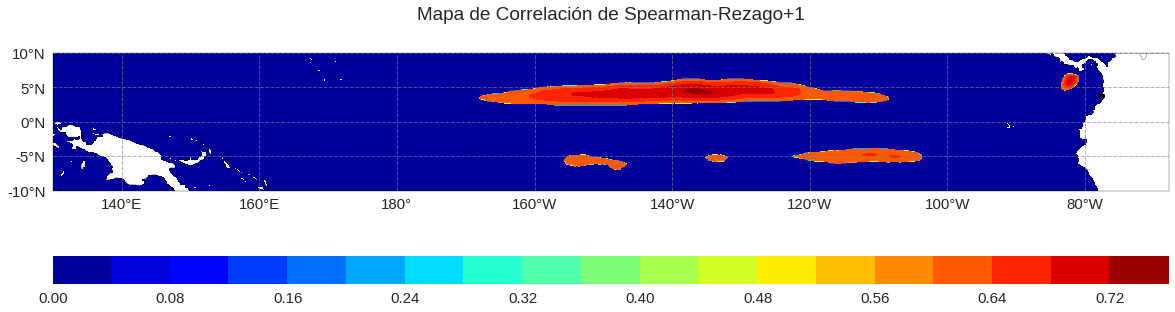

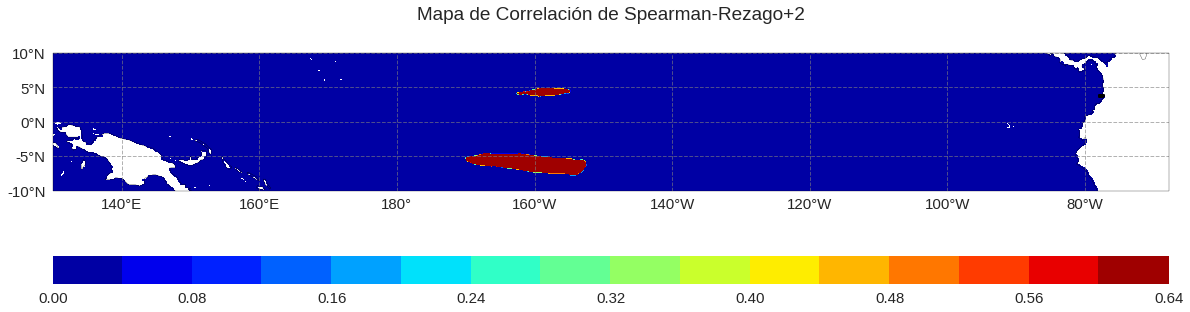

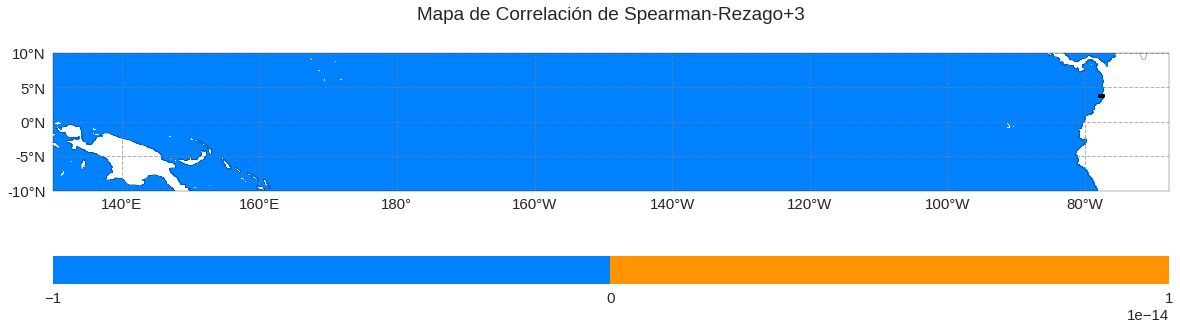

In [35]:
for i in range(n_rez):
#     region=spearman_rez[i,:,:]>=np.nanpercentile(spearman_rez[i,:,:],90)
    region=((spearman_rez[i,:,:]>0.6) | (spearman_rez[i,:,:]<-0.6))
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title("Mapa de Correlación de Spearman-Rezago+"+str(i),y=1.2,fontsize=19)
    x,y=np.meshgrid(lon,lat)
    
    cf=ax.contourf(x,y,region*spearman_rez[i,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
    gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=180), draw_labels=False,
                  ylocs=np.array([-10,-5,0,5,10]),xlocs=np.array(np.arange(-60,140,20)),linewidth=1, color='gray', alpha=0.6, linestyle='--')
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor="None", edgecolor='black',linewidth=2)
    ax.coastlines()


    ax.set_xticks(np.arange(-40, 120, 20))
    ax.set_xticklabels(x_tick_labels)


    ax.set_yticks(np.arange(-10, 11, 5))
    ax.set_yticklabels(y_tick_labels)

    cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
    cbar.ax.tick_params(labelsize=15) 

#     plt.show()

# Eligiendo la región a monitorear

In [78]:
region=spearman_rez[1,:,:]>0.7
ind_lat2,ind_lon2=np.where(region==True)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
sla_lat2=np.nanmean(ssh[:,ind_lat2],axis=1)
serie_ssh2=np.nanmean(sla_lat2[:,ind_lon2],axis=1)
serie_ssa2=pd.Series(serie_ssh2-np.mean(serie_ssh2),index=date)

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Serie de datos en la región a monitorear")
plt.plot(serie_ssa2,c="darkcyan")
plt.ylabel("sla [m]")
# plt.savefig(".\Graficas\Series.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Red Neuronal 

# Preguntas importantes

Tenemos dos preguntas de análisis:

\begin{enumerate}
    \item ¿Cuál es el efecto del ENSO en la variabilidad interanual del nivel del mar?
    \item Durante una fase cálida ¿existe una zona mar afuera que pueda servir para pronosticar el nivel del mar en regiones más costeras?
\end{enumerate}    

**1. Teniendo en cuenta que un objetivo es evaluar el efecto del ENSO en el nivel del mar**

Cómo evaluar dicho efecto más allá de:

1. realizar la EOF que permite conocer la estructura espacial y los modos de oscilación.
2. realizar gráficas de porcentajes de varianza
3. EOF Extendida

**2. Respecto al segundo gran objetivo hay muchas dudas sobre**


- ¿Cómo elegir la zona ya teniendo en cuenta los rezagos?

Ya se ha hecho:

1. Mapas de correlación con rezagos


